# Bayesian moderation analysis

**Author:** [Benjamin T. Vincent](https://github.com/drbenvincent)

This notebook covers Bayesian [moderation analysis](https://en.wikipedia.org/wiki/Moderation_(statistics)). Note that this is not _mediation_ analysis, which is different. This is not intended as a one-stop solution to a wide variety of data analysis problems, rather, it is intended as an educational exposition to show how moderation analysis works and how to conduct Bayesian parameter estimation in PyMC3.

In [1]:
import pymc3 as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

Entirely unrelated to the core concepts, we first define a helper function for plotting purposes. This function will create a Matplotlib `ScalarMappable` so we can use a consistent colormap across both data points and posterior predictive lines. We can use `scalarMap.cmap` to use as a colormap, and `scalarMap.to_rgba(moderator_value)` to grab a colour for a given moderator value.

In [2]:
def make_scalarMap(m):
    return ScalarMappable(norm=Normalize(vmin=np.min(m), vmax=np.max(m)), cmap="viridis")

# Does the effect of training upon muscularity decrease with age?

I've taken inspiration from [this example](https://www.spss-tutorials.com/spss-regression-with-moderation-interaction-effect/) by Ruben Geert van den Berg which examines whether age influences (moderates) the effect of training on muscle percentage. We might speculate that more training results in higher muscle mass, at least for younger people. But it might be the case that the relationship between training and muscle mass changes with age - perhaps training is less effective at increasing muscle mass in older age?

The schematic box and arrow notation often used to represent moderation is shown by an arrow from the moderating variable to the line between a predictor and an outcome variable.

![](moderation_figure.png)

It can be useful to use consistent notation, so we will define:
- `x` as the main predictor variable. In this example it is training.
- `y` as the outcome variable. In this example it is muscle percentage.
- `m` as the mediator. In this example it is age.

## The moderation model

While the visual schematic (above) is a useful shorthand to understand complex models when you already know what moderation is, you can't derive it from the diagram alone. So let us formally specify the moderation model - it defines an outcome variable $y$ as:

$$
y \sim \mathrm{Normal}(\beta_0 + \beta_1 \cdot x + \beta_2 \cdot x \cdot m + \beta_3 \cdot m, \sigma^2)
$$

where $y$, $x$, and $m$ are your observed data, and the following are the model parameters:
- $\beta_0$ is the intercept, its value does not have that much importance in the interpretation of this model.
- $\beta_1$ is the rate at which $y$ (muscle percentage) increases per unit of $x$ (training hours). If $\beta_1 \neq 0$ then we have a main effect of $x$. 
- $\beta_2$ is the coefficient for the moderation term $x \cdot m$. A credible non-zero $\beta_2$ could be taken as evidence for a moderation effect.
- $\beta_3$ is the rate at which $y$ (muscle percentate) increases per unit of $m$ (age). If $\beta_3 \neq 0$ then we have a main effect of $m$. 
- $\sigma$ is the standard deviation of the observation noise.

We can see that the mean $y$ is simply a mulitple linear regression with an interaction term between the two predictors, $x$ and $m$. We can get some insight into why this is the case by re-writing the model as:

$$
y \sim \mathrm{Normal}(\beta_0 + x (\beta_1 + \beta_2 \cdot m) + \beta_3 \cdot m, \sigma^2)
$$

This could be seen as a linear regression with $x$ and $m$ being predictor variables, but where $\beta_1 + \beta_2 \cdot m$ describes how the moderator linearly influences the relationship between $x$ and $y$. We can use this knowledge later to visualise the 'moderation effect' by plotting $\beta_1 + \beta_2 \cdot m$ as a function of $m$.

## Import data
First, we will load up our example data and do some basic data visualisation.

In [3]:
def load_data():
    df = pd.read_csv("../data/muscle-percent-males-interaction.csv")
    # Extract data
    x = df["thours"]
    m = df["age"]
    y = df["mperc"]
    
    # define important reference points
    true_params = {"β0": 0, "β1": 0, "β2": 0, "β3": 0, "σ": None}
    return (x, y, m, true_params)

x, y, m, true_params = load_data()

# Make a scalar color map for this dataset. Just for plotting.
scalarMap = make_scalarMap(m)

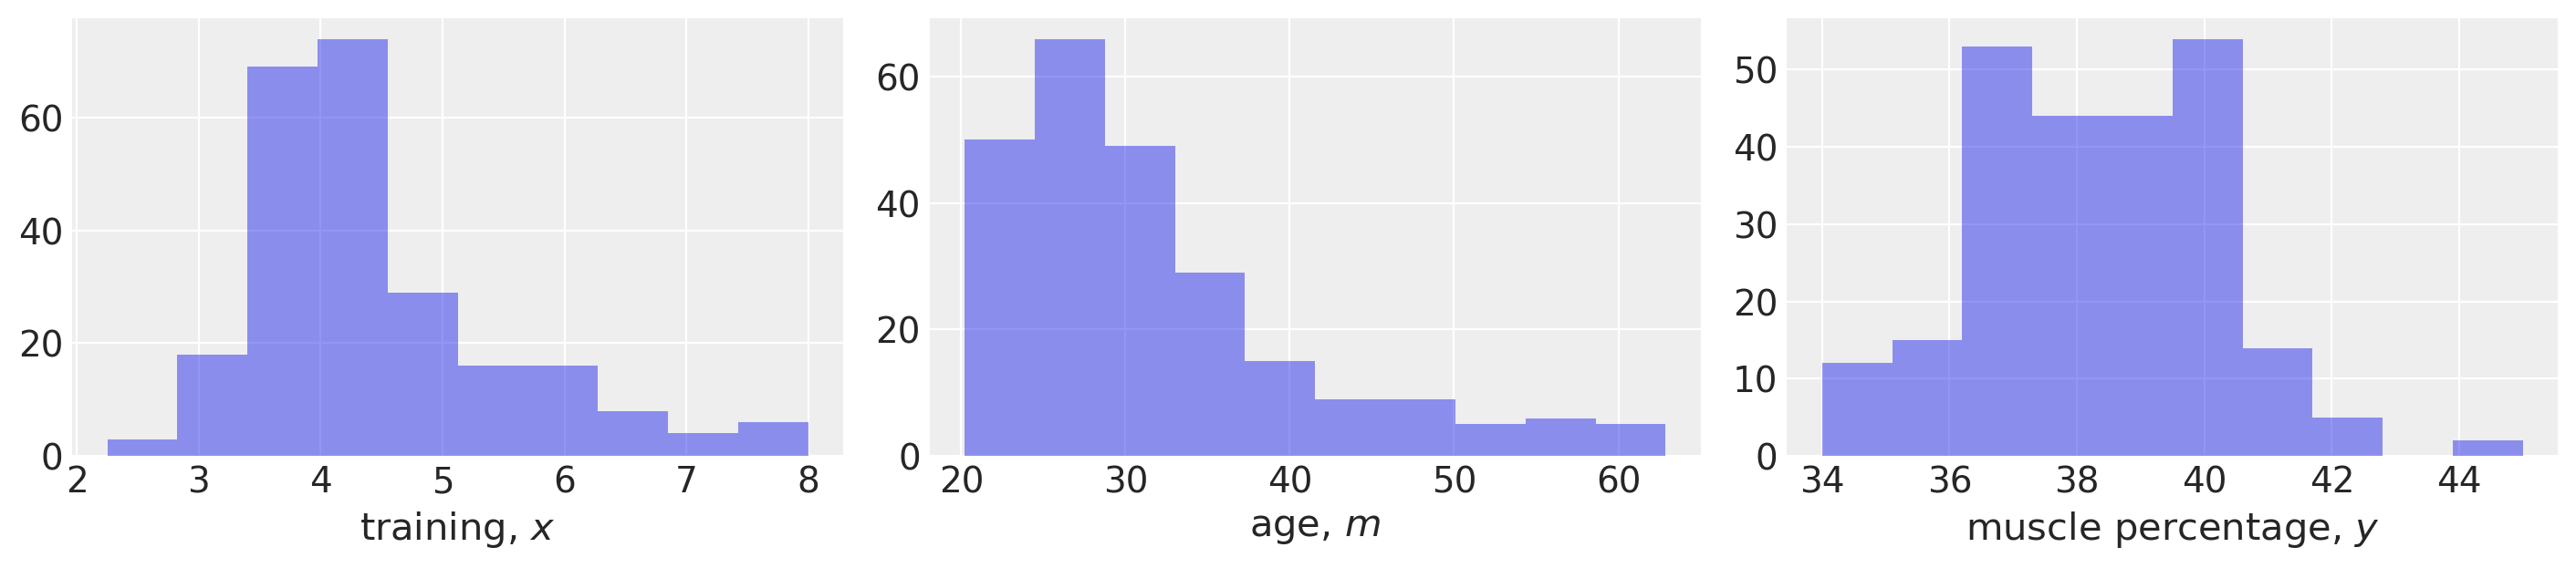

In [4]:
fig, ax = plt.subplots(1, 3, figsize=(14, 3))

ax[0].hist(x, alpha=0.5)
ax[0].set(xlabel="training, $x$")

ax[1].hist(m, alpha=0.5)
ax[1].set(xlabel="age, $m$")

ax[2].hist(y, alpha=0.5)
ax[2].set(xlabel="muscle percentage, $y$");

## Define the PyMC3 model

In [5]:
def bayesian_moderation(y, x, m):
    """Conduct simple Bayesian moderation. 
    Returns the model and the trace."""

    with pm.Model() as model:
        # priors
        β0 = pm.Normal("β0", mu=0, sd=10)
        β1 = pm.Normal("β1", mu=0, sd=10)
        β2 = pm.Normal("β2", mu=0, sd=10)
        β3 = pm.Normal("β3", mu=0, sd=10)
        σ = pm.HalfCauchy("σ", 1)
        # likelihood
        y = pm.Normal("y", mu=β0 + (β1 * x) + (β2 * x * m) + (β3 * m), sd=σ, observed=y)
        # sample
        trace = pm.sample(return_inferencedata=False)

    return model, trace

## Conduct inference

In [6]:
model, trace = bayesian_moderation(y, x, m)

n_samples = trace["β0"].shape[0]

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, β3, β2, β1, β0]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 21 seconds.
The acceptance probability does not match the target. It is 0.9026371916977433, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


Plot the model graph to confirm it is as intended.

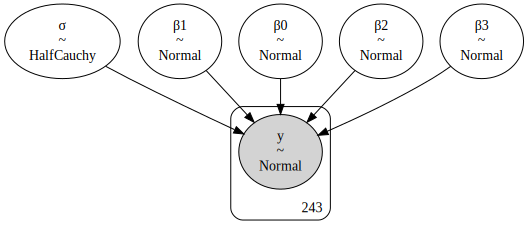

In [7]:
pm.model_to_graphviz(model)

Visualise the trace to check for convergence.

/Users/btvincent/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


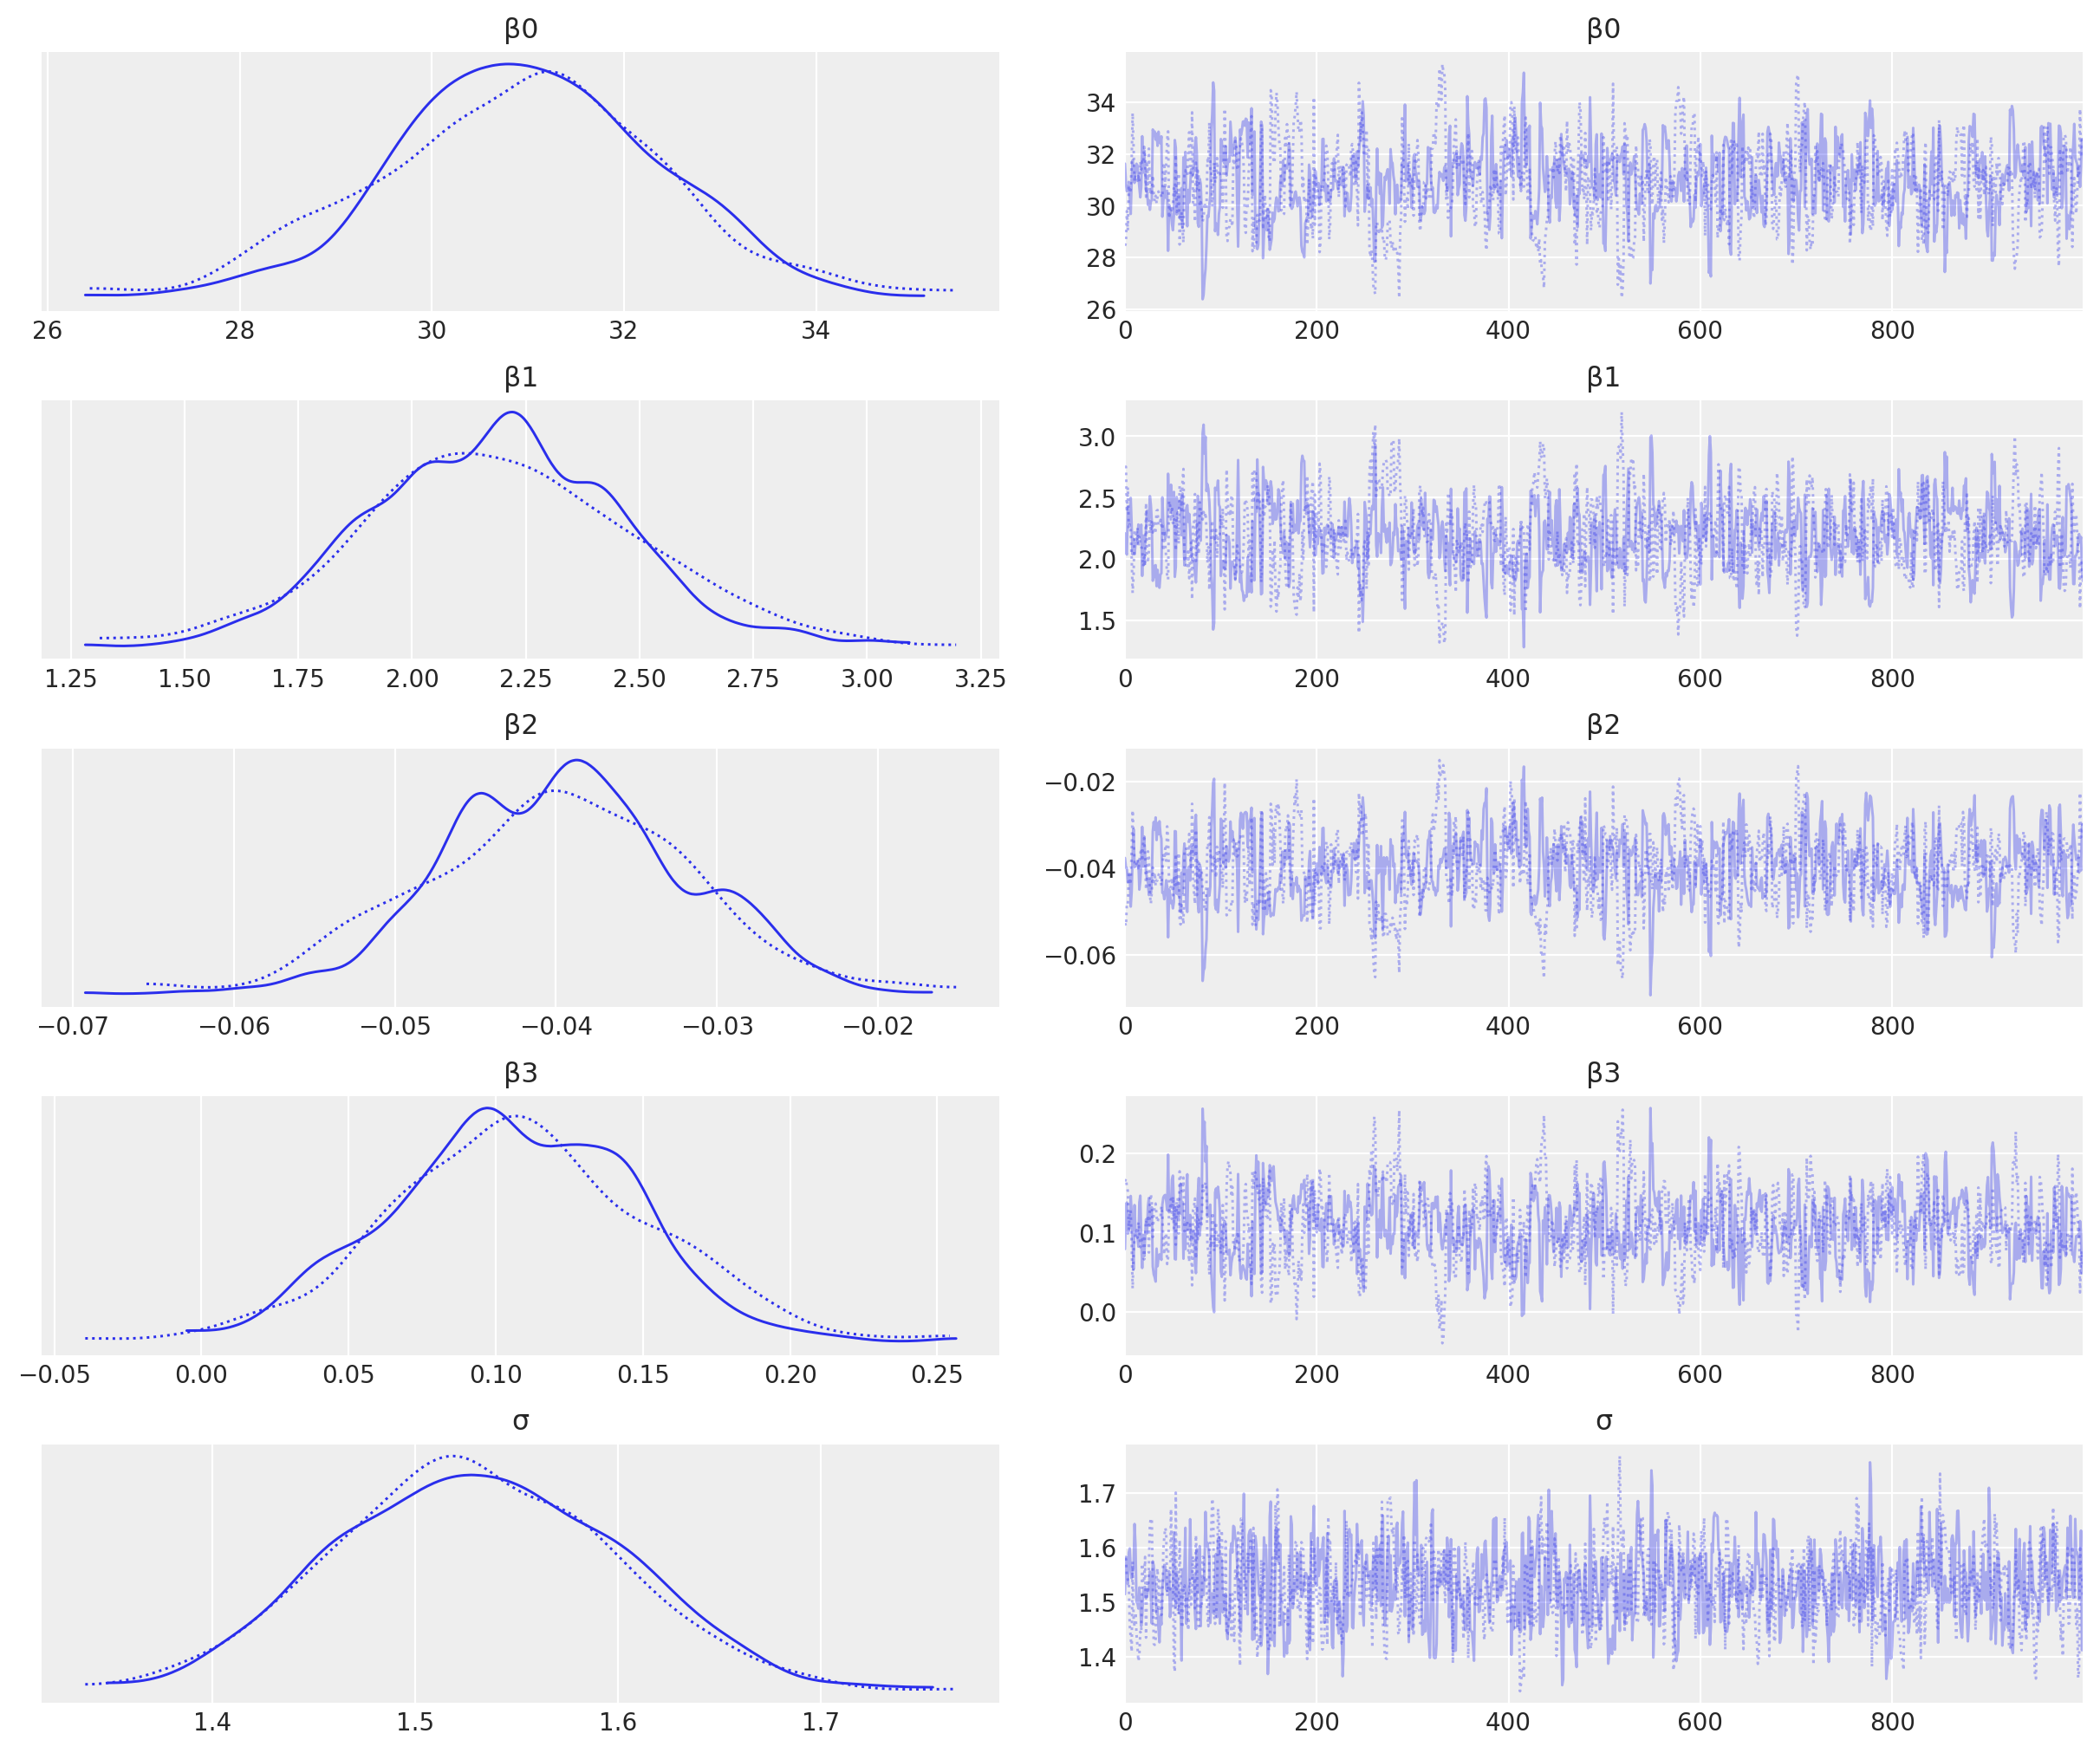

In [8]:
pm.plot_trace(trace);

We have good chain mixing and the posteriors for each chain look very similar, so no problems in that regard.

## Visualise the important parameters

First we will use a pair plot to look at joint posterior distributions. This might help us identify any estimation issues with the interaction term (see the discussion below about multicolinarity).

/Users/btvincent/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


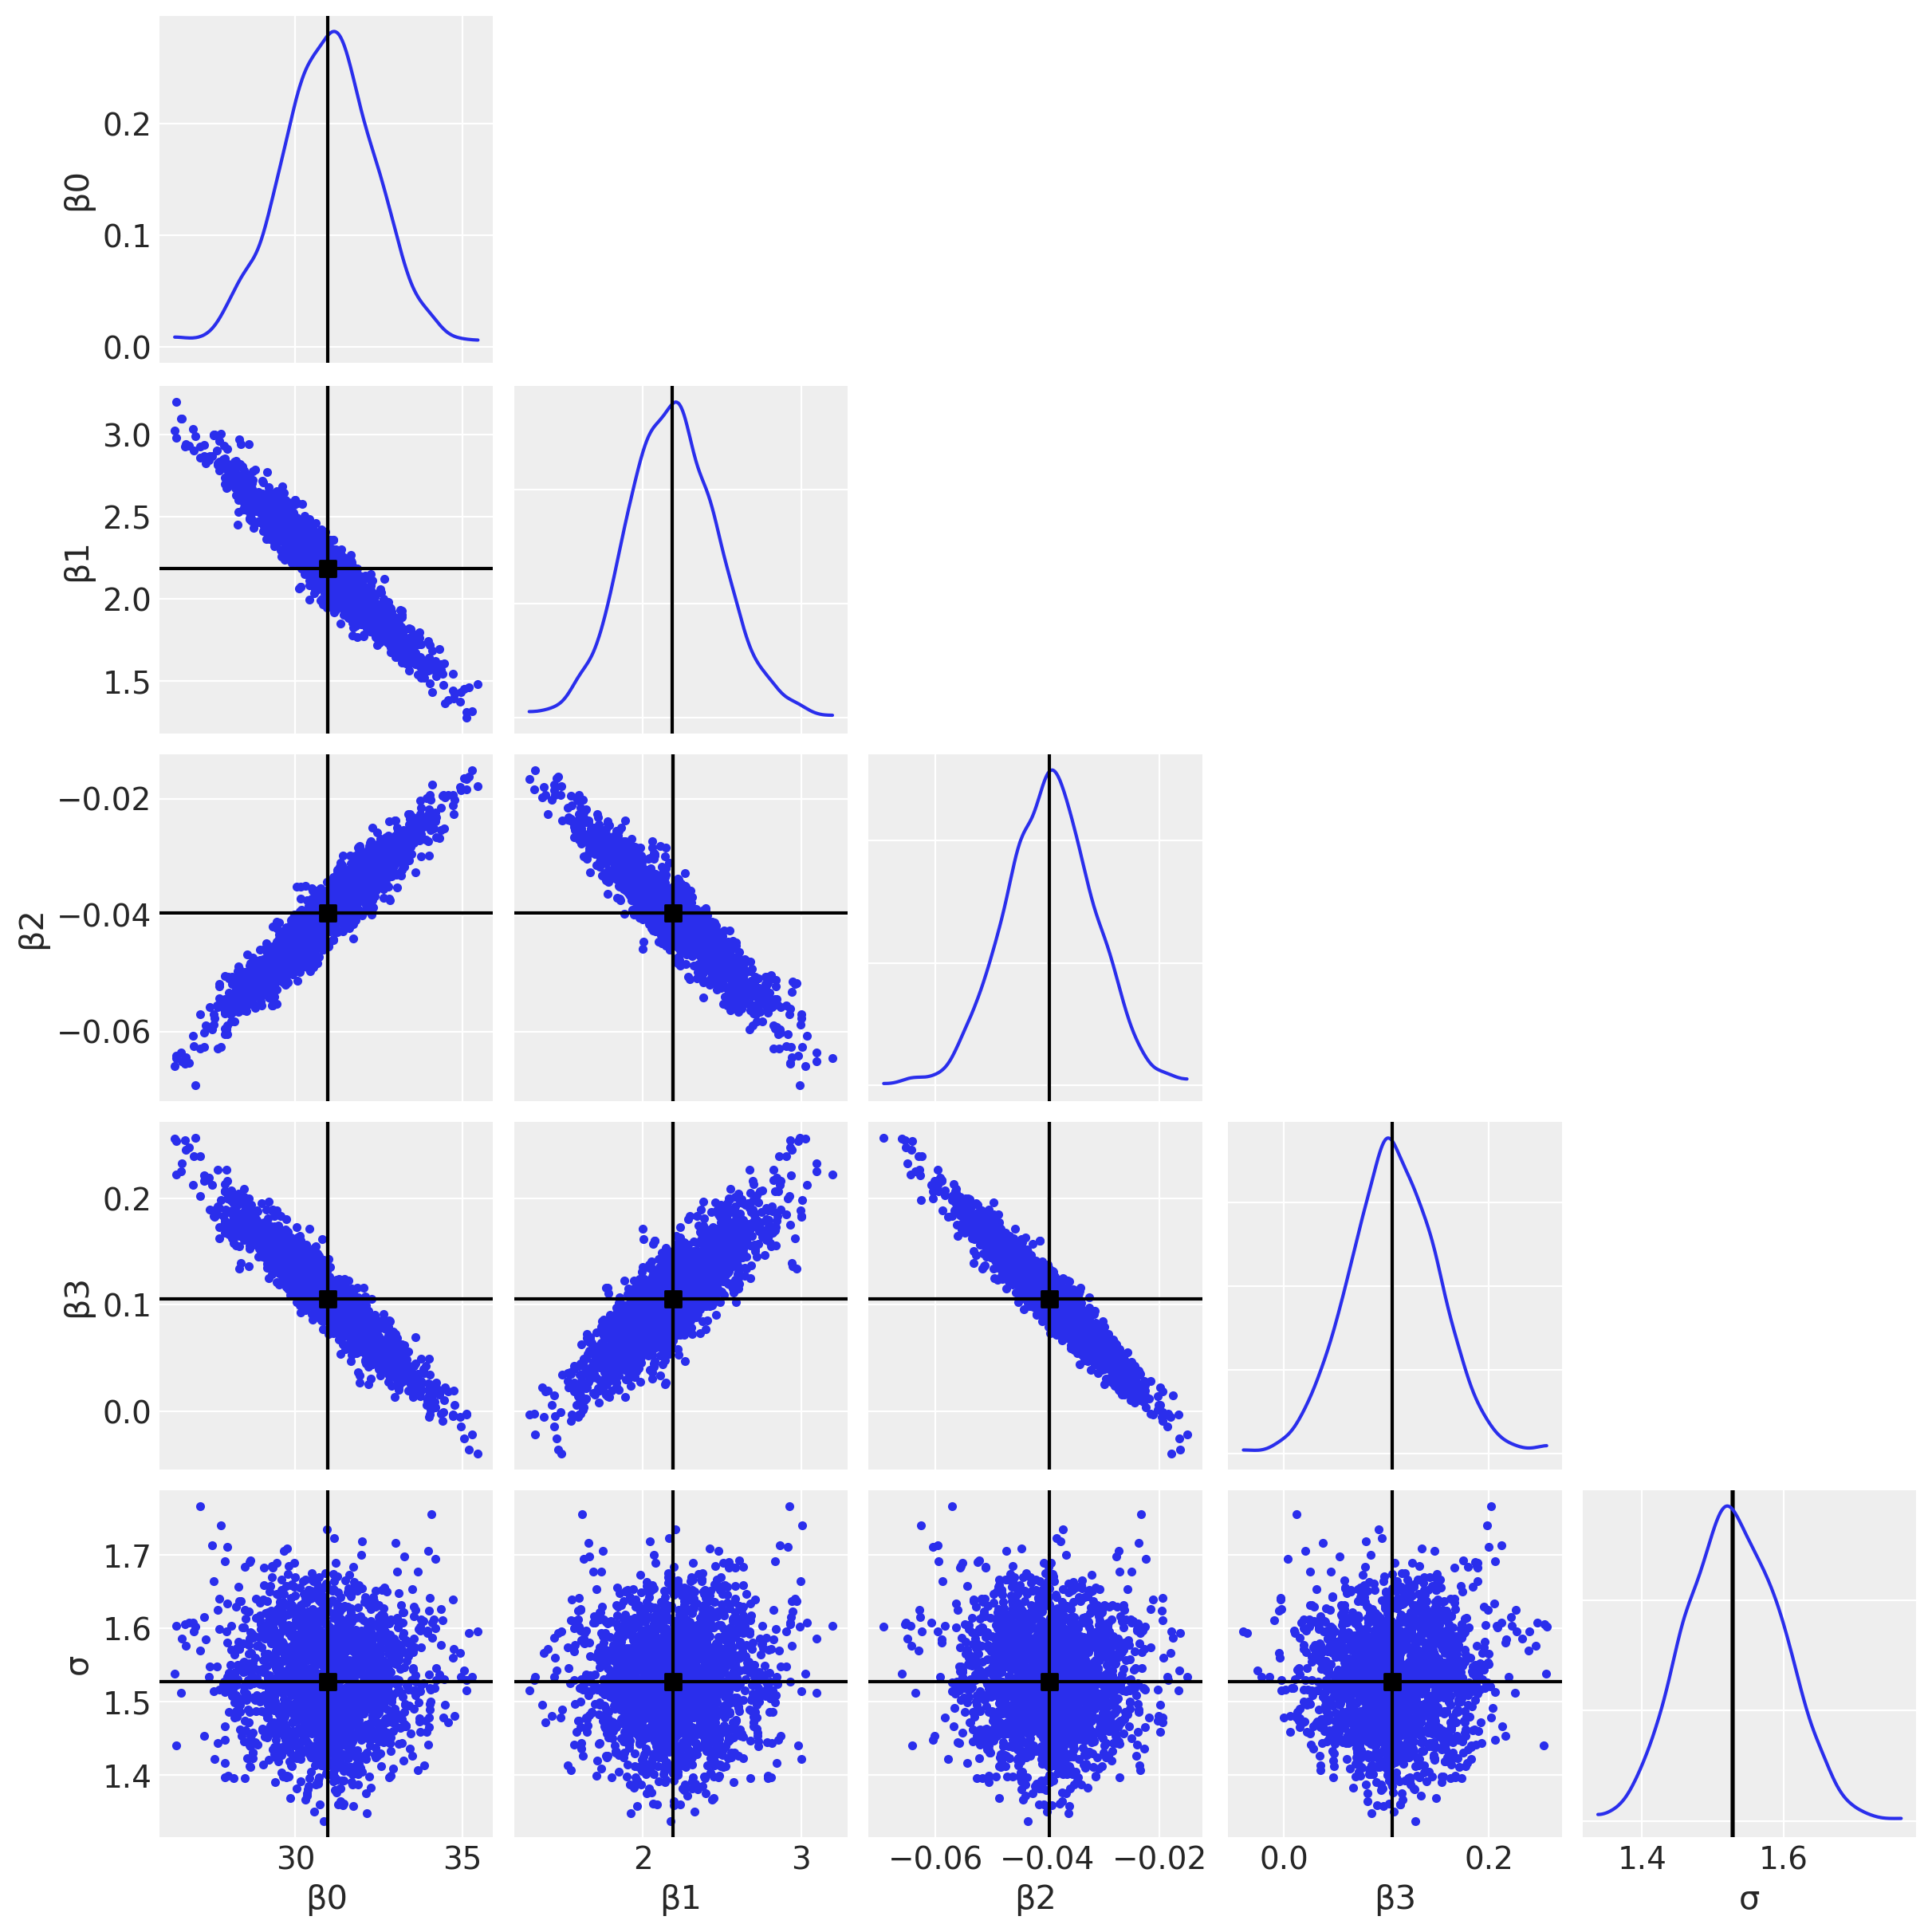

In [9]:
az.plot_pair(trace, marginals=True, point_estimate="median", figsize=(12, 12));

And just for the sake of completeness, we can plot the posterior distributions for each of the $\beta$ parameters and use this to arrive at research conclusions.

/Users/btvincent/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/btvincent/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/btvincent/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 wit

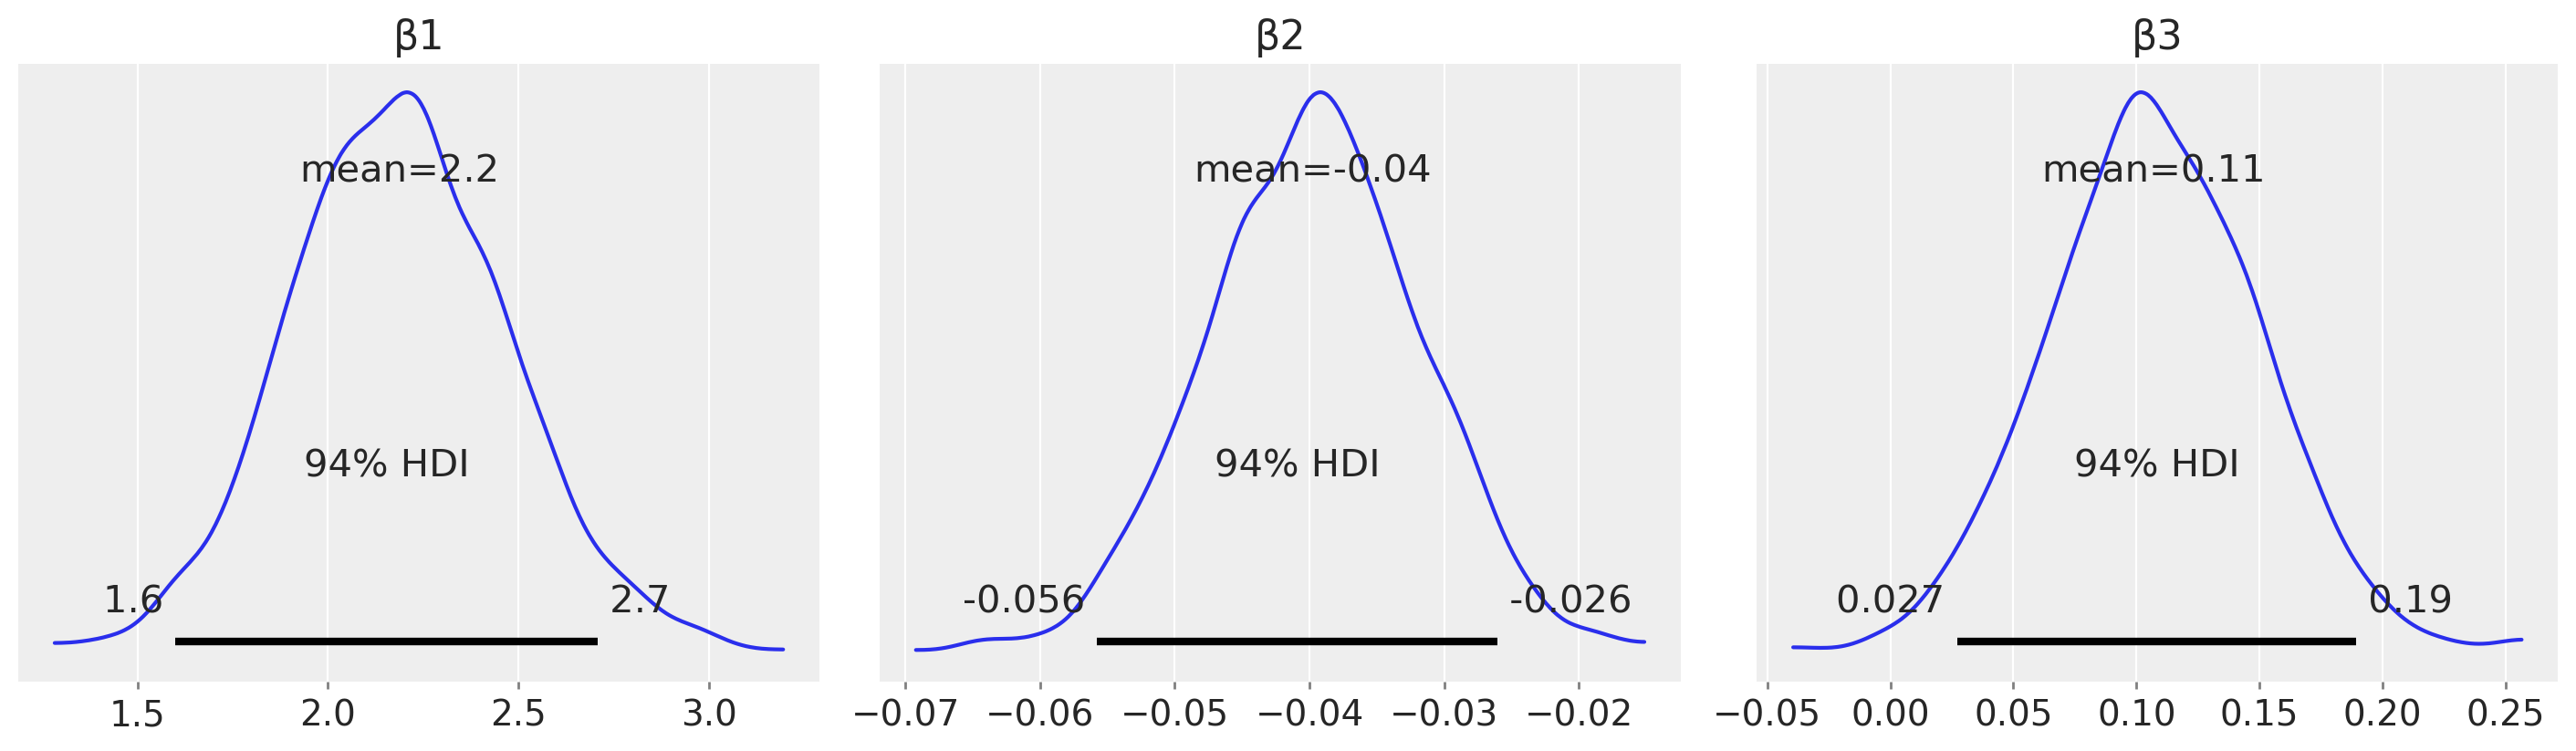

In [10]:
param_names = ["β1", "β2", "β3"]
fig, ax = plt.subplots(1, len(param_names), figsize=(14, 4))
for i, param_name in enumerate(param_names):
    az.plot_posterior(trace, var_names=param_name, ax=ax[i])

For example, from an estimation (in contrast to a hypothesis testing) perspective, we could look at the posterior over $\beta_2$ and claim a credibly less than zero moderation effect.

## Posterior predictive checks

### Visualisation in data space
Here we will plot the data alongside model poster predictive checks. This can be a useful visual method of comparing the model predictions against the data.

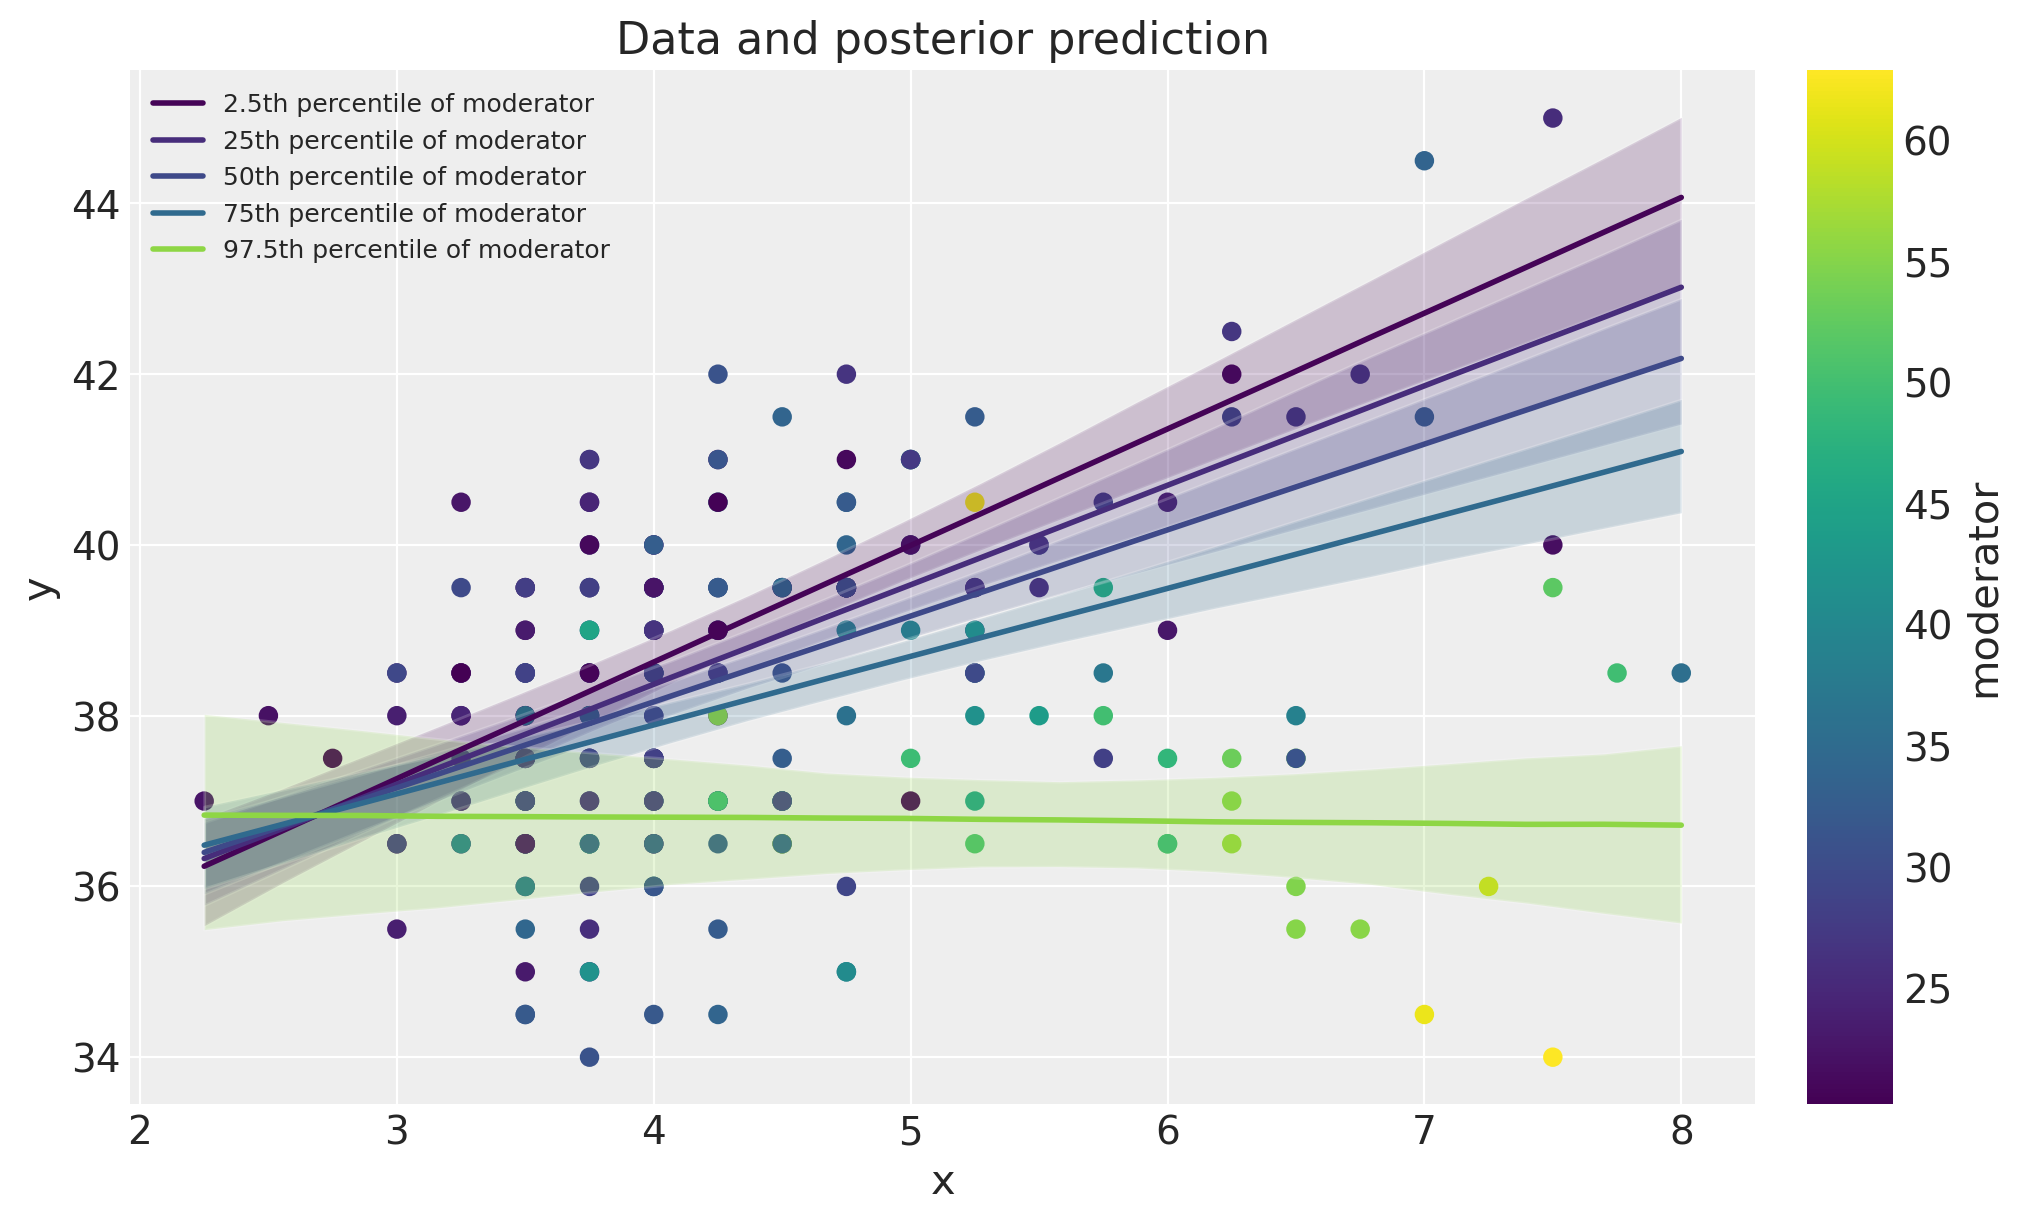

In [11]:
def plot_data(x, moderator, y, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    else:
        fig = plt.gcf()

    h = ax.scatter(x, y, c=moderator, cmap=scalarMap.cmap)
    ax.set(xlabel="x", ylabel="y")
    # colourbar for moderator
    cbar = fig.colorbar(h)
    cbar.ax.set_ylabel("moderator")
    return ax

def posterior_prediction_plot(
    trace, y, x, moderator, ax=None, percentile_list=[2.5, 25, 50, 75, 97.5]
):
    """Plot posterior predicted `y` for the defined moderator percentiles"""
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    # PLOT POSTERIOR PREDICTED `y` FOR DEFINED MODERATOR LEVELS
    xi = np.linspace(np.min(x), np.max(x), 20)
    m_levels = np.percentile(moderator, percentile_list)

    for p, m in zip(percentile_list, m_levels):
        β0 = np.expand_dims(trace["β0"], axis=1)
        β1 = np.expand_dims(trace["β1"], axis=1)
        β2 = np.expand_dims(trace["β2"], axis=1)
        β3 = np.expand_dims(trace["β3"], axis=1)
        _y = β0 + β1 * xi + β2 * xi * m + β3 * m
        region = np.percentile(_y, [2.5, 50, 95], axis=0)

        ax.fill_between(
            xi,
            region[0, :],
            region[2, :],
            alpha=0.2,
            color=scalarMap.to_rgba(m),
            edgecolor="w",
        )
        ax.plot(
            xi,
            region[1, :],
            color=scalarMap.to_rgba(m),
            linewidth=2,
            label=f"{p}th percentile of moderator",
        )

    ax.legend(fontsize=9)

    ax.set(xlabel="x", ylabel="y")
    return ax


fig, ax = plt.subplots(figsize=(10, 6))
plot_data(x, m, y, ax=ax)
posterior_prediction_plot(trace, y, x, m, ax=ax)
ax.set_title("Data and posterior prediction");

### The moderation effect
We can also visualise the 'moderation effect' by plotting $\beta_1 + \beta_2 \cdot \text{moderator}$ as a function of the $\text{moderator}$.

In [12]:
def plot_moderation_effect(m,
    ax=None,
    true_β1=None,
    true_β2=None,
    percentile_list=[0, 2.5, 25, 50, 75, 97.5, 100],
    samples_to_plot=100,
):

    if ax is None:
        fig, ax = plt.subplots(1, 1)

    m_ends = np.linspace(np.min(m), np.max(m), 2)

    # sample from posterior
    if samples_to_plot < n_samples:
        ind = np.random.choice(range(n_samples), samples_to_plot)

    β1 = np.expand_dims(trace["β1"], axis=1)[ind, :]
    β2 = np.expand_dims(trace["β2"], axis=1)[ind, :]
    rate = β1 + β2 * m_ends

    # spaghetti plot
    for n in range(samples_to_plot):
        ax.plot(m_ends, rate[n, :], "k", alpha=0.1)

    # plot true model, if known
    if (true_β1 is not None) and (true_β2 is not None):
        true = true_β1 + true_β2 * m_ends
        ax.plot(m, true, "r", lw=3, label="true")

    # plot points at each percentile of m
    m_levels = np.percentile(m, percentile_list)
    for m in m_levels:
        ax.plot(
            m, np.mean(β1) + np.mean(β2) * m, "o", c=scalarMap.to_rgba(m), markersize=10
        )

    ax.legend()

    ax.set(
        title="moderation effect",
        xlabel="$moderator$",
        ylabel=r"$\beta_1 + \beta_2 \cdot moderator$",
    )

No handles with labels found to put in legend.
/Users/btvincent/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


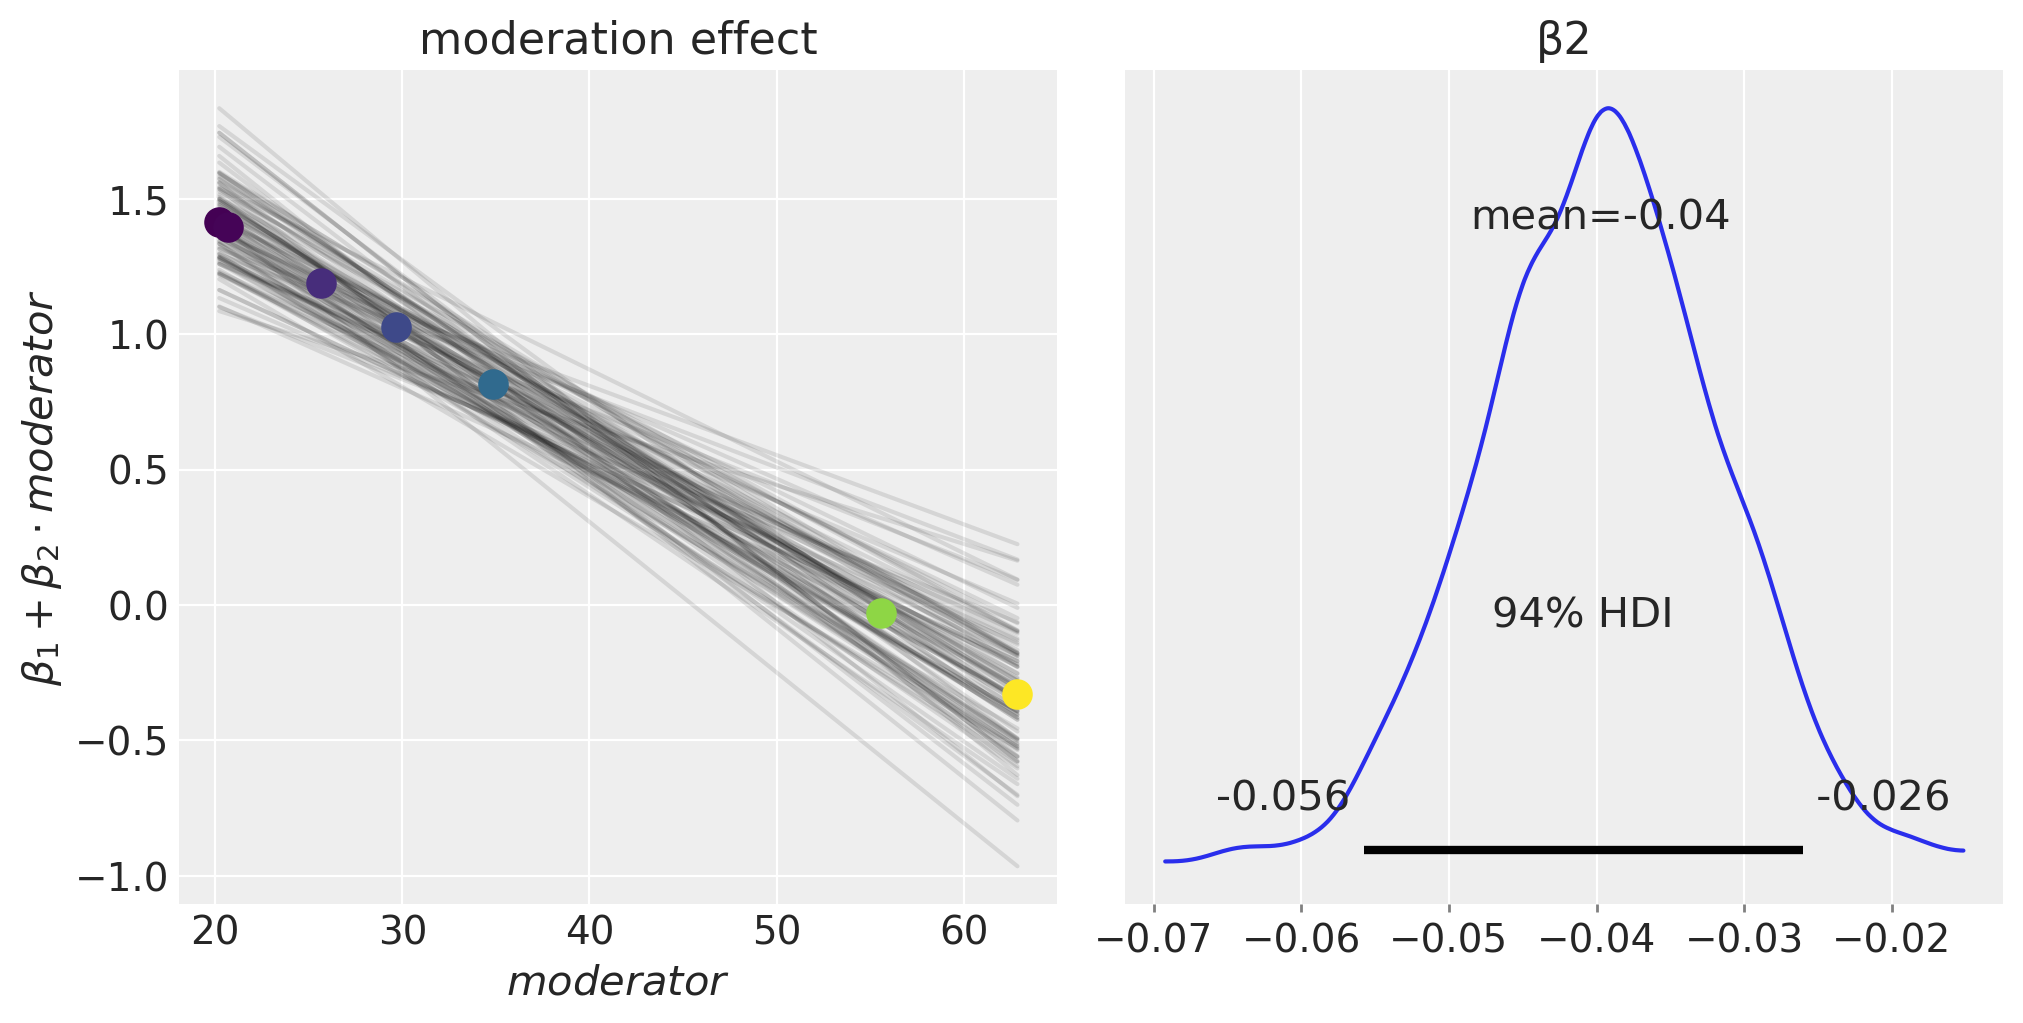

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

plot_moderation_effect(m, ax[0])
az.plot_posterior(trace, var_names="β2", ax=ax[1]);

The expression $\beta_1 + \beta_2 \cdot \text{moderator}$ defines the rate of change of the outcome (muscle percentage) per unit of $x$ (training hours/week). We can see that as age (the moderator) increases, this effect of training hours/week on muscle percentage decreases.

# Related issues: mean centering and multicolinarity

Readers should be aware that there are issues around mean-centering and multi-colinearity. The original SPSS Moderation Regression Tutorial did mean-centre the predictor variables $x$ and $m$. This will have a downstream effect upon the interaction term $x \cdot m$.

One effect of mean centering is to change the interpretation of the parameter estimates. In this notebook, we did not mean center the variables which will affect the parameter estimates and their interpretation. It is not that one is correct or incorrect, but one must be cognizant of how mean-centering (or not) affects the interpretation of parameter estimates.

Another issue, particularly relevant to moderation analysis is [multicolinarity](https://en.wikipedia.org/wiki/Multicollinearity), where one predictor variable is well-described as a linear combination of other predictors. This is clearly the case in moderation analysis as the interaction term $m \cdot x$ is by definition a linear combination of $x$ and $m$.

Iacobucci et al (2016) explored the issues of mean-centering and multicollinearity and conclude:
 > When all is said and done, should a researcher mean center the X1 and X2 variables before computing a product term X1X2 to include in a moderated multiple regression? It depends. Mean centering is advisable when: (1) the predictor variables are measured on scales with arbitrary zeros and the researcher seeks to enhance the interpretation of the regression results vis-à-vis the variables’ means rather than the arbitrary zero points, or (2) the research questions involve testing the main effect terms in addition to the interaction term and the researcher seeks to obtain these statistical tests without the interference of the so-called nonessential multicollinearity. On the other hand, mean centering may be bypassed when: (1) the research question involves primarily the test of the interaction term, with no regard for the lower order main effect terms, or (2) the research question involves primarily the assessment of the overall fit of the model, the R2, with no interest in apportioning the explained variability across the predictors, main effects or interaction alike.
 
This was critiqued however by McClelland (2016) who claimed that Iacobucci et al (2016) made a number of errors, and that multi-colinearity is a red herring:

> Multicollinearity is irrelevant to the search for moderator variables, contrary to the implications of Iacobucci, Schneider, Popovich, and Bakamitsos (Behavior Research Methods, 2016, this issue). Multicollinearity is like the red herring in a mystery novel that distracts the statistical detective from the pursuit of a true moderator relationship.

They state:

> Researchers using MMR need not compute any multicollinearity diagnostics nor worry about it at all. They need not use mean-centering or the orthogonal transformation or do anything else to avoid the purported problems of multicollinearity. The only purpose of those transformations is to facilitate understanding of MMR models.

Bearing in mind McClelland et. al.(2016) took a frequentist hypothesis testing (not a Bayesian approach) their take-home points can be paraphrased as:
1. Fit the regression model, $y \sim \mathrm{Normal}(\beta_0 + \beta_1 \cdot x + \beta_2 \cdot x \cdot m + \beta_3 \cdot m, \sigma^2)$, with original (not mean-centred) data.
2. If the main interest is on the moderation effect, then focus upon $\beta_2$.
3. Transformations are useful if conditional relationships are to be highlighted.
4. "... researchers who wish to examine all possible conditional relationships or to help their readers who might want to consider other conditional relationships, should construct the floodlight graph..." which equates to the linear "moderation effect" posterior predictive plots I have generated above.

But readers are strongly encouraged to read McClelland (2016) for more details, as well as the reply from 
Iacobucci et. al. (2017)

Further information about the "moderation effect" plots I created, corresponding to what McClelland et. al.(2016) called "spotlight graphs", can be found in Bauer and Curran (2005) and Spiller et al. (2013). Although note that these take a frequentist (not Bayesian) perspective.

# References

- Bauer, D. J., & Curran, P. J. (2005). Probing interactions in fixed and multilevel regression: Inferential and graphical techniques. Multivariate Behavioral Research, 40, 373–400.
- [SPSS Moderation Regression Tutorial](https://www.spss-tutorials.com/spss-regression-with-moderation-interaction-effect/) by Ruben Geert van den Berg
- Iacobucci, D., Schneider, M.J., Popovich, D.L. et al. (2016) Mean centering helps alleviate “micro” but not “macro” multicollinearity. Behav Res 48, 1308–1317. https://doi.org/10.3758/s13428-015-0624-x
- Iacobucci, D., Schneider, M.J., Popovich, D.L. et al. (2017) Mean centering, multicollinearity, and moderators in multiple regression: The reconciliation redux. Behav Res 49, 403–404. https://doi.org/10.3758/s13428-016-0827-9
- McClelland, G.H., Irwin, J.R., Disatnik, D. et al. (2017) Multicollinearity is a red herring in the search for moderator variables: A guide to interpreting moderated multiple regression models and a critique of Iacobucci, Schneider, Popovich, and Bakamitsos (2016). Behav Res 49, 394–402 . https://doi.org/10.3758/s13428-016-0785-2
- Spiller, S. A., Fitzsimons, G. J., Lynch, J. G., & McClelland, G. H. (2013). Spotlights, floodlights, and the magic number zero: Simple effects tests in moderated regression. Journal of Marketing Research, 50, 277–288.

In [14]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Apr 06 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.21.0

matplotlib: 3.3.4
pandas    : 1.2.3
arviz     : 0.11.2
numpy     : 1.19.2
pymc3     : 3.11.2

Watermark: 2.2.0

